In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

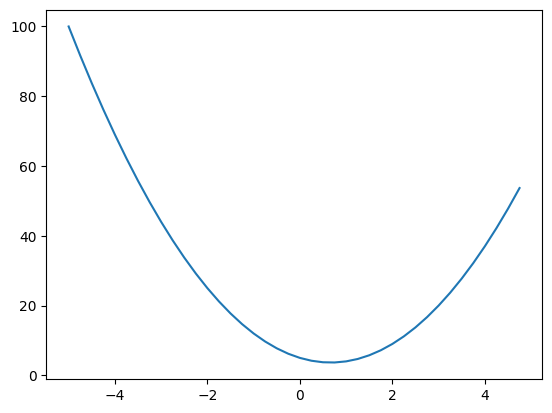

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs,ys)

In [5]:
h = 0.000000000001
x = 2/3
(f(x+h) - f(x))/h

-0.0004440892098500626

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b+c
print(d)

4.0


In [7]:
h = 0.00001
a = 2.0
b = -3.0
c = 10

d1 = a*b+c
c += h
d2= a*b+c

print ( 'd1', d1 )
print ( 'd2', d2 )
print ( 'slope', (d2-d1)/h )

d1 4.0
d2 4.00001
slope 0.9999999999621422


In [8]:
class Value:
    def __init__(self,data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data},op={self._op})"

    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data+other.data, (self,other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self,other):
        return self + other
    
    def __sub__(self,other):
        return self + (-other)
        
    def __mul__(self,other):        
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data*other.data, (self,other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1
    
    def __truediv__(self, other):
        return self * other ** -1
    
    def __rmul__(self, other):
        return self * other
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward       
        return out
    
    def __pow__(self, other):
        assert isinstance(other,(int,float))
        
        out = Value(self.data ** other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * ( self.data ** (other - 1) ) * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        out = Value(t, (self,), 'tanh' )
        
        def _backward():
            self.grad += (1-t**2) * out.grad
            
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)        
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [9]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
         if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %0.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name= uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

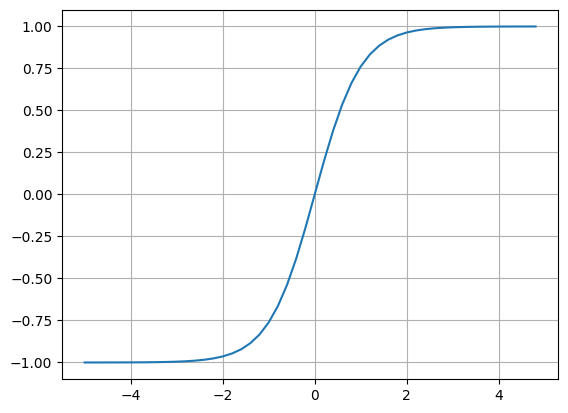

In [10]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

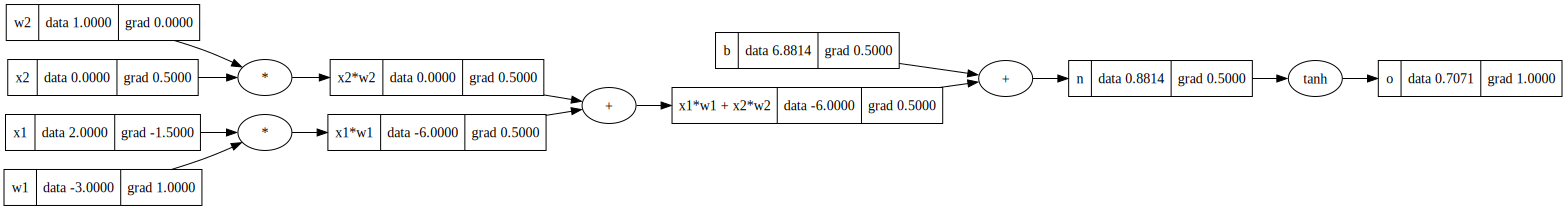

In [11]:
# Input
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias
b = Value(6.88137358, label='b')

# Neuron
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

o.backward()
draw_dot(o)

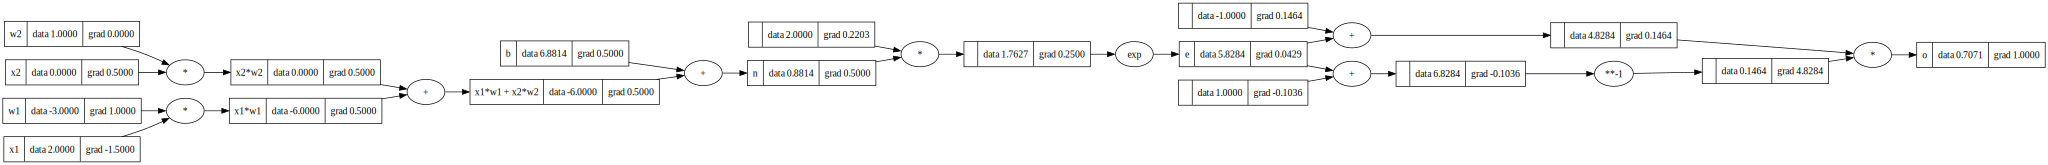

In [12]:
# Input
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias
b = Value(6.88137358, label='b')

# Neuron
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp(); e.label = 'e'
o = (e-1)/(e+1); o.label = 'o'

o.backward()
draw_dot(o)

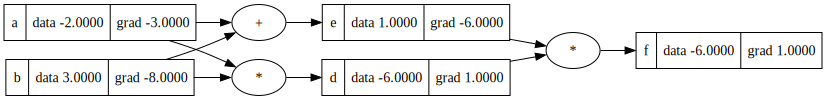

In [13]:
# Handle multiple reference to each node
a = Value(-2.0, label = 'a')
b = Value(3.0, label = 'b')
d = a*b; d.label = 'd'
e = a + b; e.label = 'e'
f = d*e; f.label = 'f'

f.backward()

draw_dot(f)

In [14]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.88137358]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print( '---' )
print ( 'x2', x2.grad.item() )
print ( 'w2', w2.grad.item() )
print ( 'x1', x1.grad.item() )
print ( 'w1', w1.grad.item() )



0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [57]:
import random 

class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self,x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

class Layer:
    def __init__(self, nin, nout ):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs

class Perceptron:
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
x = [2.0, 3.0, -1.0]
n = Perceptron(3, [4, 4, 1])
n(x)

Value(data=-0.09662983028248802,op=tanh)

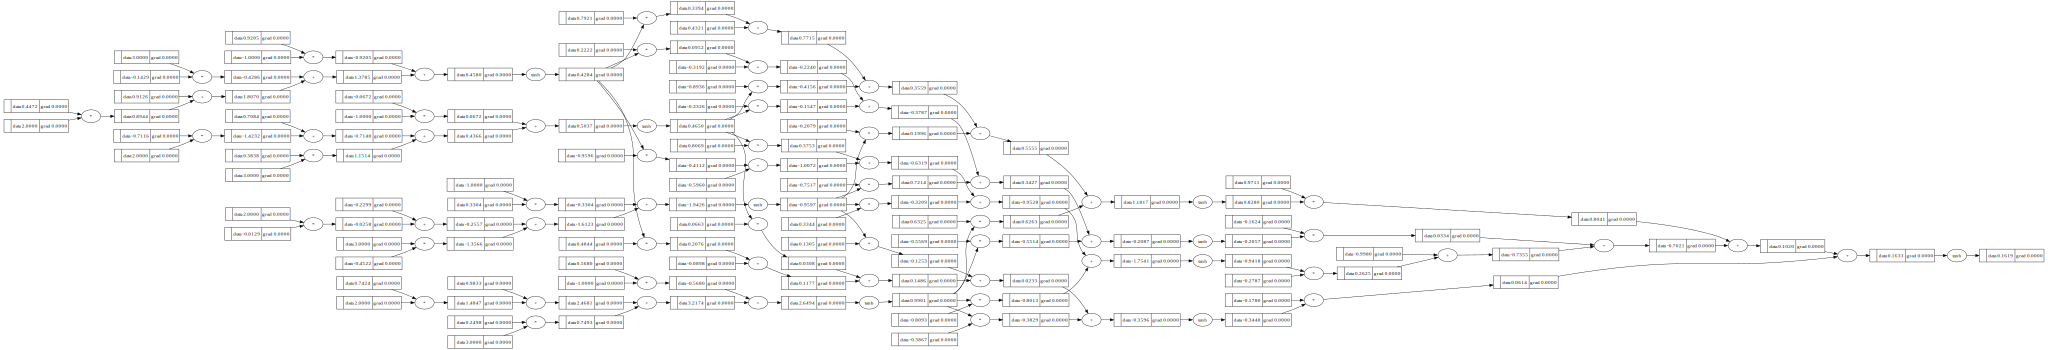

In [45]:
draw_dot(n(x))

In [58]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

ypred = [n(x) for x in xs]
ypred

[Value(data=-0.09662983028248802,op=tanh),
 Value(data=0.24767701807689751,op=tanh),
 Value(data=0.17101454722913578,op=tanh),
 Value(data=-0.039476379489998485,op=tanh)]

In [61]:
loss = sum((yout - ygt)**2 for ygt , yout in zip(ys, ypred))
loss

Value(data=5.21108113944255,op=+)

In [66]:
loss.backward()
n.layers[0].neurons[0].w[0].grad

-13277.018300615757

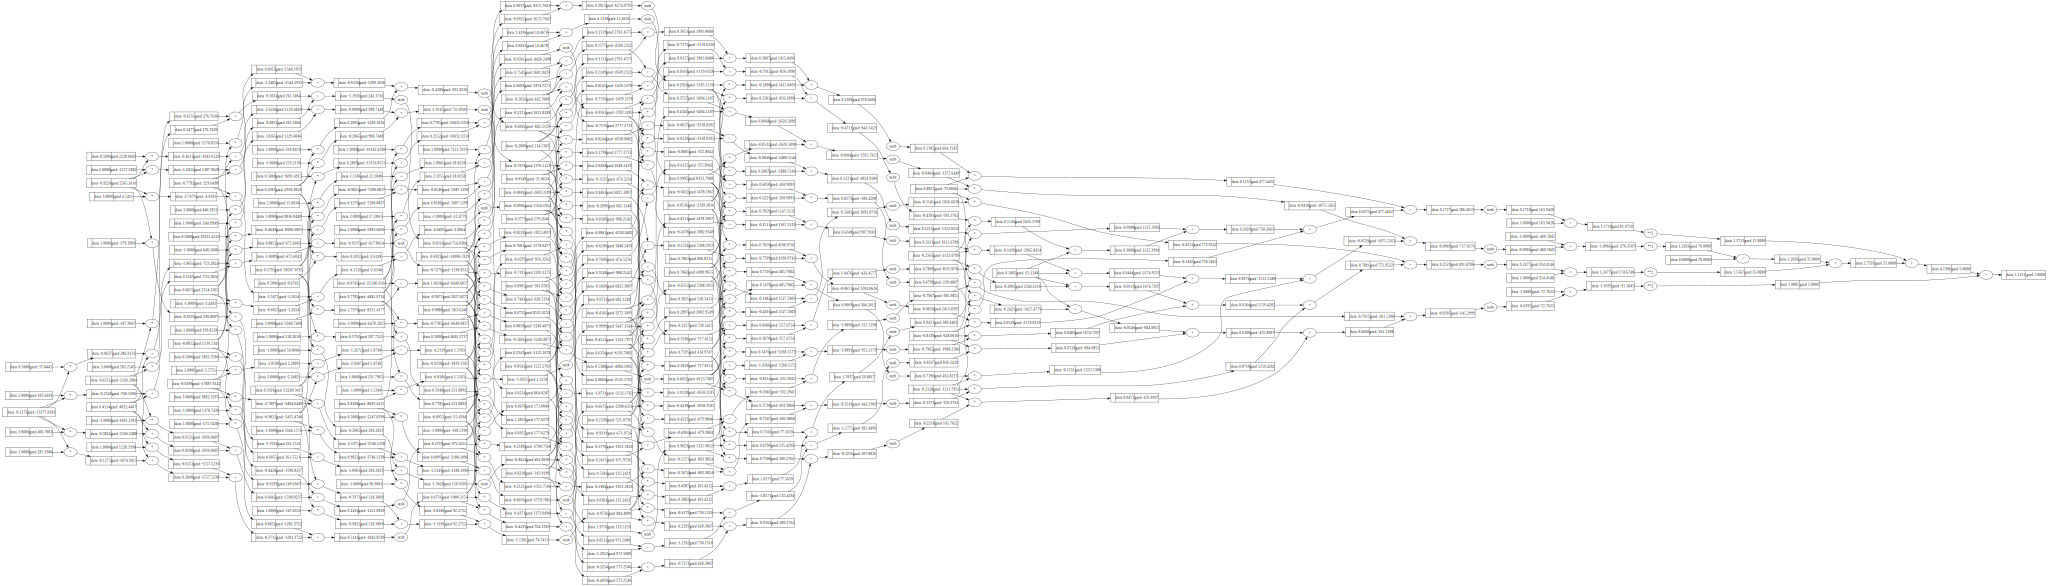

In [67]:
draw_dot(loss)